In [869]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit



In [862]:
data = pd.read_csv("./data.csv")
print(data.head())

# subjects n = 78
n_subjects = max(data["subject"])
n_blocks = max(data["block"])
print("n blocks: ", n_blocks)

train_data = data[data["subject"] < (n_subjects - 40)]
train_data = data[data["subject"] < (n_subjects - 10)]
test_data = data[data["subject"] >= (n_subjects - 10)]


y_train = train_data["RT_trimmed"].to_numpy()
y_test = test_data["RT_trimmed"].to_numpy()

# -- Special --  ##
all_y = data["RT_trimmed"].to_numpy()

X_train = train_data["shape_num"].to_numpy()
X_test = test_data["shape_num"].to_numpy()

print(X_train[1])
print(y_train[1])


"""
Size of trial: 24 * 24
"""

def gen_data(d):
    data = np.empty((0, 24))
    for index in d:
        #print("item?: ", index)
        # Create an array of zeros with length 24
        result_array = np.zeros(24)
        result_array[d[index] - 1] = 1
        data = np.vstack((data, result_array))
    return data

X_train = gen_data(X_train)
X_test = gen_data(X_test)




"""
X_train = np.reshape(X_train, ((int(X_train.shape[0] / (24*24))), 24*24, 24))
X_test = np.reshape(X_test, ((int(X_test.shape[0] / (24*24))), 24*24, 24))

y_train = np.reshape(y_train, (int(y_train.size / (24* 24)), 24*24, 1))
y_test = np.reshape(y_test, (int(y_test.size / (24 * 24)), 24*24, 1))
"""

X_train = np.reshape(X_train, ((int(X_train.shape[0] / (24))), 24, 24))
X_test = np.reshape(X_test, ((int(X_test.shape[0] / (24))), 24, 24))

y_train = np.reshape(y_train, (int(y_train.size / (24)), 24, 1))
y_test = np.reshape(y_test, (int(y_test.size / (24)), 24, 1))




   subject         ave          sd  block  triplet  position  shape_num    RT  \
0        1  463.309028  298.476633      1        1         1          1  1121   
1        1  463.309028  298.476633      1        1         2          2   886   
2        1  463.309028  298.476633      1        1         3          3   837   
3        1  463.309028  298.476633      1        7         1         19   843   
4        1  463.309028  298.476633      1        7         2         20  1264   

    RT_trimmed  log_RT_trimmed  change?  block>12  block>18  block>6  \
0  1060.262293        6.966272        1     False     False    False   
1   886.000000        6.786717        0     False     False    False   
2   837.000000        6.729824        0     False     False    False   
3   843.000000        6.736967        0     False     False    False   
4  1060.262293        6.966272        1     False     False    False   

   1-avg(2,3)  log_1-avg(2,3) odd_even  
0         NaN             NaN        o 

In [863]:
def build_network(learning_rate: float = 0.003):
     model = tf.keras.Sequential()
     model.add(tf.keras.Input(shape=(1, 24)))
     model.add(tf.keras.layers.SimpleRNN(6, return_sequences = False, activation = "linear"))
     model.add(tf.keras.layers.Dense(1, activation = "linear"))
     loss = tf.keras.losses.CategoricalCrossentropy()
     model.compile(optimizer = \
        #tf.keras.optimizers.Adam(learning_rate = learning_rate), loss = loss, metrics = ["accuracy"])	
        #tf.keras.optimizers.Adam(learning_rate = learning_rate), loss='mean_squared_error', metrics = ["accuracy"])
      tf.keras.optimizers.Adam(
         learning_rate = learning_rate), 
         loss='mean_squared_error', 
         metrics=[
            tf.keras.metrics.mean_squared_error,
            tf.keras.metrics.mean_absolute_error,
            tf.keras.metrics.mean_absolute_percentage_error]
         )
     return model

In [864]:
def train_model():
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    #res = model.fit(X_train, y_train, epochs = 200, validation_data = (X_test, y_test))
    res = model.fit(X_train, y_train, epochs = 20, validation_data = (X_test, y_test))
    return res

In [865]:
def show_res(res, verbose: bool = False):
    print(res.history.keys())
    if verbose:
        print(res.history)
    fig, axs = plt.subplots(2,2)
    axs[0, 0].set_title("training loss")
    axs[0, 0].plot(res.history["loss"])
    axs[0, 1].set_title("mean_squared_error")
    axs[0, 1].plot(res.history["mean_squared_error"])
    axs[1, 0].set_title("val_mean_absolute_percentage_error")
    axs[1, 0].plot(res.history["val_mean_absolute_percentage_error"])
    axs[1, 1].set_title("val_mean_absolute_error")
    axs[1, 1].plot(res.history["val_mean_absolute_error"])
    plt.show()

(1464, 24, 24) (1464, 24, 1) (216, 24, 24) (216, 24, 1)
Epoch 1/20
46/46 [==============================] - 1s 7ms/step - loss: 1085194.1130 - mean_squared_error: 1085194.1130 - mean_absolute_error: 754.4256 - mean_absolute_percentage_error: 96.2454 - val_loss: 898717.5625 - val_mean_squared_error: 898717.5625 - val_mean_absolute_error: 563.8187 - val_mean_absolute_percentage_error: 73.8656
Epoch 2/20
46/46 [==============================] - 0s 3ms/step - loss: 560226.4043 - mean_squared_error: 560226.4043 - mean_absolute_error: 492.9109 - mean_absolute_percentage_error: 93.5444 - val_loss: 865032.8750 - val_mean_squared_error: 865032.8750 - val_mean_absolute_error: 563.1691 - val_mean_absolute_percentage_error: 78.9615
Epoch 3/20
46/46 [==============================] - 0s 7ms/step - loss: 509328.1629 - mean_squared_error: 509328.1629 - mean_absolute_error: 476.4930 - mean_absolute_percentage_error: 91.7770 - val_loss: 912794.8125 - val_mean_squared_error: 912794.8125 - val_mean_absol

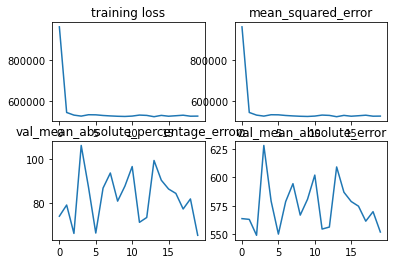

In [866]:
train_size, test_size = 480, 96 # downscale to make data set smaller (and training faster)

model = build_network()
res = train_model()
model.summary()

print("model predictions", model.predict(X_test))
print("test scores", y_test)
show_res(res)

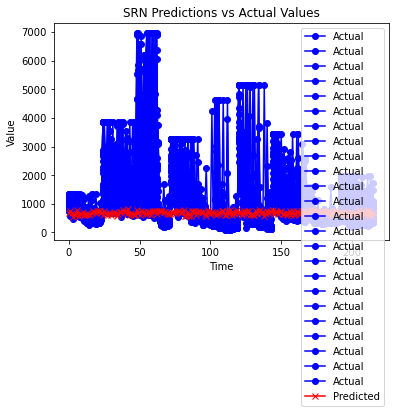

In [867]:
plt.plot(np.squeeze(y_test), label='Actual', color='blue', marker='o')
plt.plot(model.predict(X_test), label='Predicted', color='red', marker='x')
#print(np.squeeze(y_train))

# Set labels and title
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('SRN Predictions vs Actual Values')

# Add legend
plt.legend()

# Show the plot
plt.show()

shape;  (72, 24) (72, 24) (72, 24)
RT: 1007.6173187256944 950.0825255729168 942.4843111822918
log-transofrmed RT: 6.603442502171013 6.558994466716343 6.557637208326447
shape (24,)
smthng (72, 24)
--> 0.1819719041843646


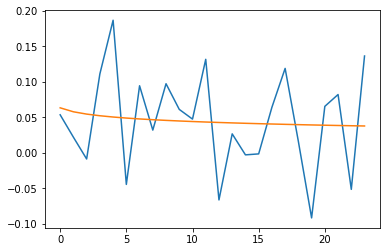

shape;  (3, 24) (3, 24) (3, 24)
RT: 688.7195 681.2448 682.8174
log-transofrmed RT: 6.530616 6.519842 6.5227923
shape (24,)
smthng (3, 24)
--> -0.1414566


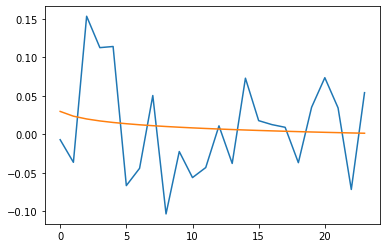

shape;  (560, 24) (560, 24) (560, 24)
RT: 834.5221229060863 798.8069684598884 790.6033008233409
log-transofrmed RT: 6.427755401534558 6.392093019528584 6.384974467753364
shape (24,)
smthng (560, 24)
--> -0.22930464472090417


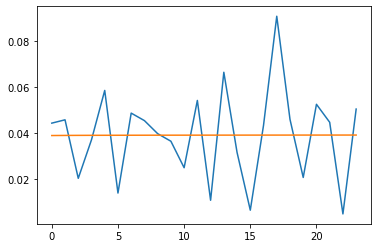

In [902]:
pred = model.predict(X_test)
new_y_test = y_test.reshape(-1, 1)
all_y = all_y.reshape(-1, 1)

pred_reshaped = pred.reshape(-1, 3)
test_reshaped = new_y_test.reshape(-1, 3)
all_reshaped = all_y.reshape(-1, 3)

reshaped_matrix = test_reshaped.reshape(-1, 24, test_reshaped.shape[1])
reshaped_matrix2 = pred_reshaped.reshape(-1, 24, pred_reshaped.shape[1])
# Sanity test
all_reshaped = all_reshaped.reshape(-1, 24, all_reshaped.shape[1])


# Define the logarithmic function
def logarithmic_func(x, a, b):
    return a * np.log(x) + b


def fit_log(x_data, y_data):
    # Fit the model
    params, covariance = curve_fit(logarithmic_func, x_data, y_data)
    # Extract the parameters
    a, b = params
    # Generate fitted y values
    y_fit = logarithmic_func(x_data, a, b)
    return y_fit

def data_anal(data):
    # Values
    first_column = data[:, :, 0]
    second_column = data[:, :, 1]
    third_column = data[:, :, 2]
    
    print("shape; ", first_column.shape, second_column.shape, third_column.shape)

    # Bereken online_measure
    online_measure = np.log(first_column) - ( (np.log(second_column) + np.log(third_column)) / 2 )
    # Alternatief
    # online_measure = np.log(first_column) - np.mean(np.log(np.stack((second_column, third_column), axis=-1)), axis=-1)
    
    print("RT:", np.mean(first_column), np.mean(second_column), np.mean(third_column))
    print("log-transofrmed RT:", np.mean(np.log(first_column)), np.mean(np.log(second_column)), np.mean(np.log(third_column)))
    
    fit = fit_log(range(1,24+1), np.mean(online_measure, axis=0))

    print("shape", np.mean(online_measure, axis=0).shape)
    print("smthng", online_measure.shape)
    print("-->", online_measure[0,1])
    plt.plot(np.mean(online_measure, axis=0))
    plt.plot(fit)
    plt.show()


data_anal(data=reshaped_matrix)
data_anal(data=reshaped_matrix2)
data_anal(data=all_reshaped)

